In [ ]:
%matplotlib notebook

In [2]:
import numpy as np
from multiprocessing import Pool
import matplotlib.pyplot as plt

In [3]:
def ribbon(xc,yc,rot,l,w,resolution=1):
    # input of rotate is degree, thus rot has unit of de
    # here just calculate one ribbon coordinate instead of whole box to save computation resource
    x = np.arange(0,l,resolution)
    y = np.arange(0,w,resolution)
    xx,yy = np.meshgrid(x - l/2,y - w/2)
    xx = xx.flatten()
    yy = yy.flatten()
    xx_new = xx*0
    yy_new = yy*0
    rot = np.radians(rot)
    rot_mat = np.array([[np.cos(rot),-np.sin(rot)],[np.sin(rot),np.cos(rot)]])
    coord = np.vstack((xx,yy))
    coord = np.matmul(rot_mat,coord)
    coord[0] += xc
    coord[1] += yc
    return coord

In [4]:
def ribbon_within_imag(xx,yy,xc,yc,rot,l,w,resolution=1):
    # input of rotate is degree, thus rot has unit of de
    # here just calculate one ribbon coordinate instead of whole box to save computation resource
    shape = xx.shape
    xx = xx.flatten() - xc
    yy = yy.flatten() - yc
    rot = np.radians(rot)
    rot_mat = np.array([[np.cos(rot),-np.sin(rot)],[np.sin(rot),np.cos(rot)]])
    coord = np.vstack((xx,yy))
    coord = np.matmul(rot_mat,coord)
    xx = coord[0].reshape(shape)
    yy = coord[1].reshape(shape)
    im = ((np.abs(xx)<=l/2)&(np.abs(yy)<=w/2)).astype(int)
    return im

In [5]:
def initial_state_ribbon(size,l,w,vol_ratio,rot=0,
                         max_l=None,max_w=None,resolution=1):
    # here assume the ribbon is irregular hexogonal aligned within the box, 
    # number of particle determined by vol_ratio
    # 
    if isinstance(max_l,type(None)):
        max_l = l*1.1
    else:
        max_l = max_l
    if isinstance(max_w,type(None)):
        max_w = w*1.3
    else:
        max_w = max_w
    # 
    box_area  = size**2
    n = int((box_area/(l*w)*vol_ratio))
    #print(n)
    ax = max_l
    ix = int(np.round(size/ax))
    ay = max_w
    iy = int(np.round(size/ay))
    x0 = []
    y0 = []
    j  = 0
    i  = 0
    pn = 0 # particle number
    xpos = 0
    ypos = 0
    while pn < n:
        #print(j)
        if j%2 == 0:
            xpos = i*ax+l/2
            ypos = j*ay+w/2
            if (size - xpos) > +l/2:
                x0.append(i*ax+l/2)
                #print(i*ax+radius)
                y0.append(j*ay+w/2)
                i  += 1
                pn += 1
            else:
                j += 1
                i = 1
                x0.append(0.5*ax+l/2)
                y0.append(j*ay+w/2)
                pn += 1
        else:
            xpos = i*ax+0.5*ax+l/2
            ypos = j*ay+w/2
            if (size - xpos) > l:
                x0.append(i*ax+0.5*ax+l/2)
                y0.append(j*ay+w/2)
                i  += 1
                pn += 1
            elif 0 <= (size - xpos) < l:
                x0.append(i*ax+0.5*ax+l/2)
                y0.append(j*ay+w/2)
                x0.append(i*ax+0.5*ax+l/2-size)
                y0.append(j*ay+w/2)
                j  += 1
                i  = 0
                pn += 1
            else:
                i  = 0
                j  += 1
                x0.append(i*ax+l/2)
                y0.append(j*ay+w/2)
                i  += 1
                pn += 1
        
    xx,yy = np.meshgrid(np.arange(0,int(size),resolution),
                        np.arange(0,int(size),resolution))
    im = xx*0
    for i in range(n):
        im1 = ribbon_within_imag(xx,yy,x0[i],y0[i],rot,l,w,resolution=1)
        im += im1
    return im,x0,y0,xx,yy

In [18]:
l = 6
w = 2
#max_l     = 7
#max_w     = 3
vol_ratio = 0.6
size = 51
im_0,x_0,y_0,xx,yy = initial_state_ribbon(size,l,w,vol_ratio,rot=0,
                         max_l=l*1.3,max_w=w*1.2,resolution=0.25)

<IPython.core.display.Javascript object>


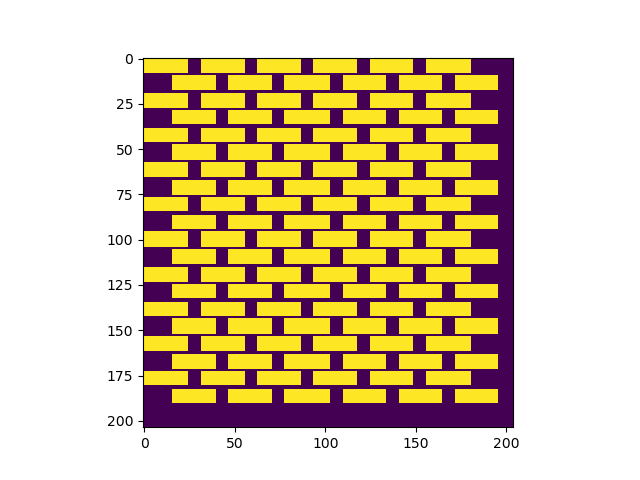

In [19]:
plt.subplots()
plt.imshow(im_0)

In [20]:
x0_old = np.copy(x_0)
y0_old = np.copy(y_0)

In [54]:
def random_walk_ribbon(iteration,step,sigma_rot,x0,y0,im,xx,yy,l,w,resolution=0.2):
    rot = np.zeros((len(x0),))
    coord = []
    for i in range(len(x0)):
        coord.append(ribbon(x0[i],y0[i],rot[i],l,w))
    coord = np.array(coord)
    radius = np.max((l,w))*2
    
    for j in range(iteration):
        for i in range(len(x0)):
            x_old = np.copy(x0[i])
            y_old = np.copy(y0[i])
            rot_old = np.copy(rot[i])
            
            u   = np.random.uniform(0,1,1)*step
            phi = np.radians(np.random.uniform(0,360,1))
            x_new = np.copy(x0[i]) + u*np.cos(phi)
            y_new = np.copy(y0[i]) + u*np.sin(phi)
            rot0   = np.random.normal(0,sigma_rot)
            #considering particle close to edge or leave box from one side will enter from another side
            if x_new > size:
                x_new = x_new - size
            if y_new > size:
                y_new = y_new - size
                
            if x_new < 0:
                x_new = x_new + size
            if y_new < 0:
                y_new = y_new + size
            coord_new = np.array(ribbon(x_new,y_new,rot0,l,w))
            #coord_new = coord_new.reshape((1,coord_new.shape[0],coord_new.shape[1]))
            #coord_new = np.tile(coord_new,(int(len(x0)-1),1,1))
            '''
            mini_dist = radius
            for _ in range(len(x0)):
                if _ == i:
                    pass
                else:
                    if ((x_new-x0[_])**2+(y_new-y0[_])**2)**0.5 >2*radius:
                        pass
                    else:
                        for __ in range(coord_new.shape[1]):
                            for ___ in range(coord_new.shape[1]):
                                #print(__,___,coord[_,0,__] - coord_new[0,___])
                                dist = ((coord[_,0,__] - coord_new[0,___])**2+
                                        (coord[_,1,__] - coord_new[1,___])**2)**.5
                                mini_dist = np.min((mini_dist,dist))
                                #print(mini_dist)
            x_new_array = np.delete(x0,i) - x_new
            y_new_array = np.delete(y0,i) - y_new
            dist = (x_new_array**2+y_new_array**2)**.5
                
            if np.size(dist[dist<radius*2]) > 0:
                
            if mini_dist < 1:
            '''
            x_new_array = np.abs(np.delete(x0,i) - x_new)
            y_new_array = np.abs(np.delete(y0,i) - y_new)
            if (np.size(x_new_array[(x_new_array<l)&(y_new_array<w)])>0):
                    #print(np.size(x_new_array[x_new_array<l]))
                    #print(np.size(dist[dist<radius*2]))
                    #print(1)
                    x0[i] = x_old
                    y0[i] = y_old
                    rot[i] = rot_old
            else:                
                x0[i] = x_new
                y0[i] = y_new
                rot[i] = rot0
                coord[i,:] = coord_new
                            
        if j%100 == 0:
            print(f'{j} iterations finished')
            
    im = xx*0
    for i in range(len(x0)):
        im1 = ribbon_within_imag(xx,yy,x0[i],y0[i],rot[i],l,w,resolution=resolution)
        im += im1
    return im,x0,y0,rot

In [21]:
def random_walk_ribbon(iteration,step,sigma_rot,x0,y0,im,xx,yy,l,w,resolution=0.2):
    rot = np.zeros((len(x0),))
    #coord = []
    #for i in range(len(x0)):
    #    coord.append(ribbon(x0[i],y0[i],rot[i],l,w))
    #coord = np.array(coord)
    radius = np.max((l,w))*2
    
    for j in range(iteration):
        for i in range(len(x0)):
            x_old = np.copy(x0[i])
            y_old = np.copy(y0[i])
            rot_old = np.copy(rot[i])
            
            u   = np.random.uniform(0,1,1)*step
            phi = np.radians(np.random.uniform(0,360,1))
            x_new = np.copy(x0[i]) + u*np.cos(phi)
            y_new = np.copy(y0[i]) + u*np.sin(phi)
            rot0   = np.random.normal(0,sigma_rot)
            #considering particle close to edge or leave box from one side will enter from another side
            if x_new > size:
                x_new = x_new - size
            if y_new > size:
                y_new = y_new - size
                
            if x_new < 0:
                x_new = x_new + size
            if y_new < 0:
                y_new = y_new + size
            coord_new = np.array(ribbon(x_new,y_new,rot0,l,w))
            #coord_new = coord_new.reshape((1,coord_new.shape[0],coord_new.shape[1]))
            #coord_new = np.tile(coord_new,(int(len(x0)-1),1,1))
            
            mini_dist = radius
            for _ in range(len(x0)):
                if _ == i:
                    pass
                else:
                    #if ((x_new-x0[_])**2+(y_new-y0[_])**2)**0.5 >2*radius:
                    #    pass
                    #else:
                    coord = ribbon(x0[_],y0[_],rot[_],l,w)
                    for __ in range(coord_new.shape[1]):
                        for ___ in range(coord_new.shape[1]):
                            #print(__,___,coord[_,0,__] - coord_new[0,___])
                            dist = ((coord[0,__] - coord_new[0,___])**2+
                                    (coord[1,__] - coord_new[1,___])**2)**.5
                            mini_dist = np.min((mini_dist,dist))
                                #print(mini_dist)
            #x_new_array = np.delete(x0,i) - x_new
            #y_new_array = np.delete(y0,i) - y_new
            #dist = (x_new_array**2+y_new_array**2)**.5
                
            #if np.size(dist[dist<radius*2]) > 0:
                
            if mini_dist < 1.2:
                x0[i] = x_old
                y0[i] = y_old
                rot[i] = rot_old
            else:
                #x_new_array = np.abs(np.delete(x0,i) - x_new)
                #y_new_array = np.abs(np.delete(y0,i) - y_new)
                #if (np.size(x_new_array[(x_new_array<l)&(y_new_array<w)])>0):
                        #print(np.size(x_new_array[x_new_array<l]))
                        #print(np.size(dist[dist<radius*2]))
                        #print(1)
                #        x0[i] = x_old
                #        y0[i] = y_old
                #        rot[i] = rot_old
                #else:                
                x0[i] = x_new
                y0[i] = y_new
                rot[i] = rot0
                #coord[i,:] = coord_new

        if j%100 == 0:
            print(f'{j} iterations finished')
            
    im = xx*0
    for i in range(len(x0)):
        im1 = ribbon_within_imag(xx,yy,x0[i],y0[i],rot[i],l,w,resolution=resolution)
        im += im1
    return im,x0,y0,rot

In [ ]:
iteration = 1000
step = w/2
x0   = np.copy(x_0)
y0   = np.copy(y_0)
im   = np.copy(im_0)
xx   = xx
yy   = yy
size   = size
l = 6
w = 2
size = 51
sigma_rot = 4
im_new,x0_new,y0_new,rot_new = random_walk_ribbon(iteration,step,sigma_rot,x0,y0,im,xx,yy,l,w,resolution=1)

0 iterations finished
100 iterations finished
200 iterations finished


<IPython.core.display.Javascript object>


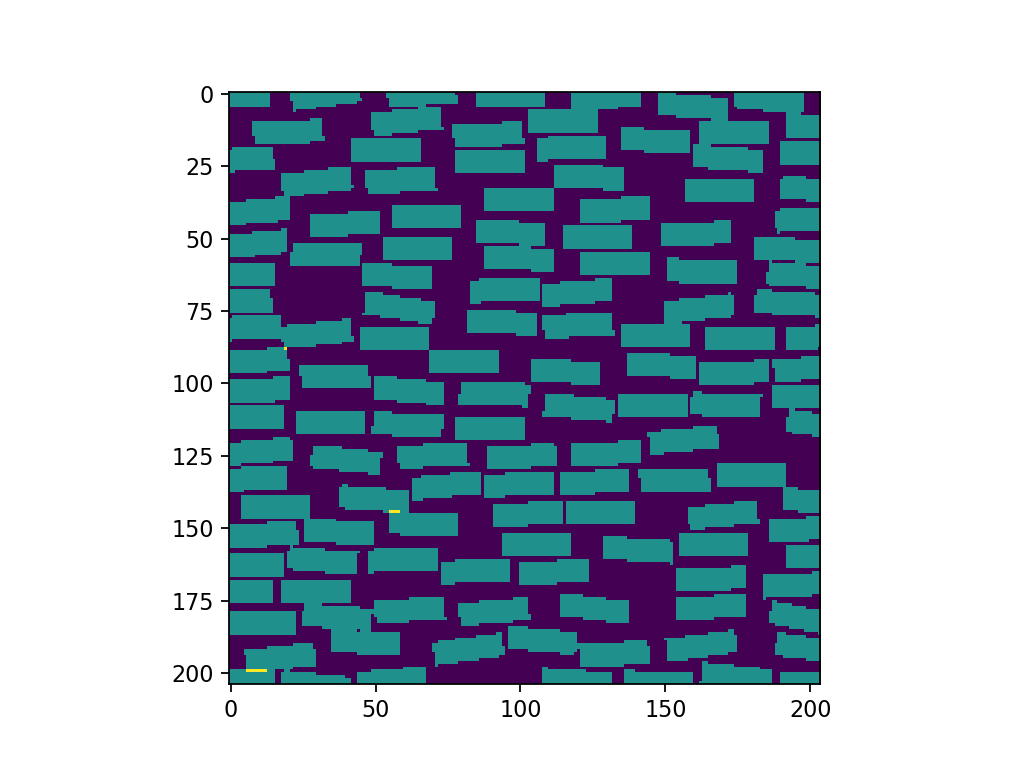

In [32]:
plt.subplots()
plt.imshow(im_new)


In [11]:
x0_new[10],x0[10],x_0[0]

(5.159701610835348, 5.159701610835348, 3.0)

In [ ]:
qx,qy = np.meshgrid(np.linspace(-0.8,0.8,301),np.linspace(-0.8,0.8,301))
def diffraction_pttn(im,xx,yy,qx,qy):
    im = im.flatten()
    xx = xx.flatten()*10
    yy = yy.flatten()*10
    pttn_shape = qx.shape
    qx = qx.flatten()
    qy = qy.flatten()
    real_space = np.vstack((xx,yy)).T
    reciprocal_space = np.vstack((qx,qy))
    im = im.reshape(len(im),1)
    im = np.tile(im,(1,len(qx)))
    fourier = np.exp(1j*np.matmul(real_space,reciprocal_space))
    pttn = im*fourier
    pttn = np.sum(pttn,axis=0)
    pttn = pttn.reshape(pttn_shape)
    return np.abs(pttn)**2

pttn = diffraction_pttn(im_0,xx,yy,qx,qy)
pttn_new = diffraction_pttn(im_new,xx,yy,qx,qy)

In [1]:
plt.subplots()
plt.imshow(im_new)

plt.subplots()
plt.imshow(np.log(pttn_new),extent=(-0.8,0.8,-0.8,0.8),vmin=7,vmax=15)

NameError: name 'plt' is not defined

In [46]:
np.sum(im)/251**2,np.sum(im_new)/251**2

(0.253281693941366, 0.26167838605736415)

<IPython.core.display.Javascript object>


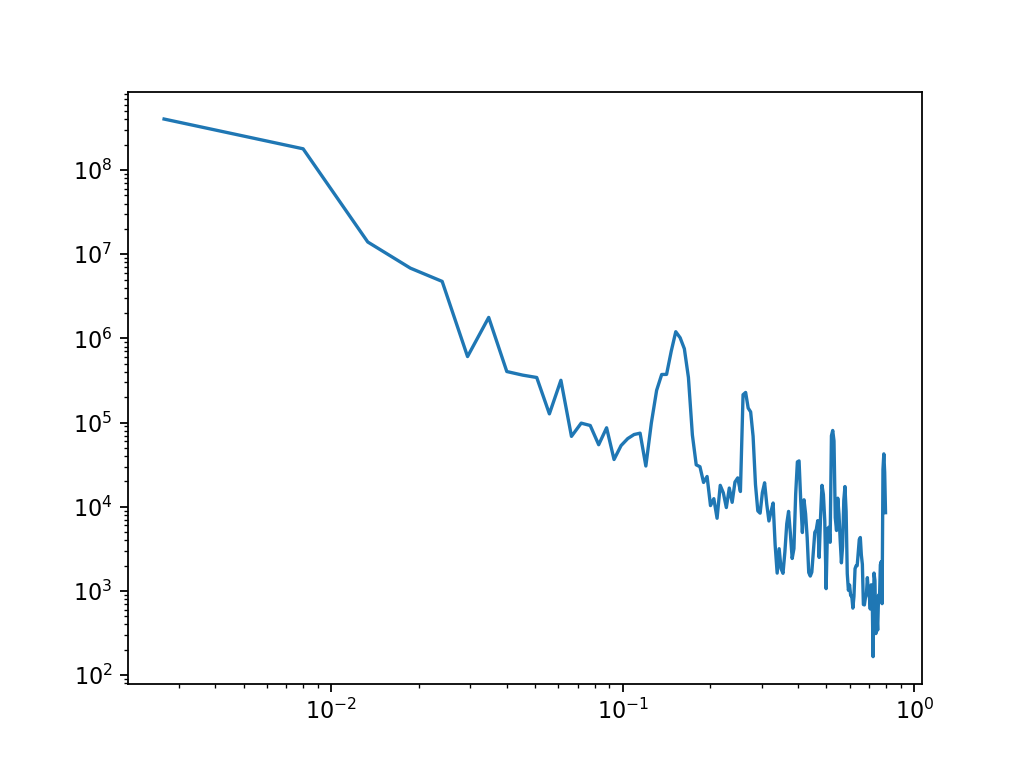

<IPython.core.display.Javascript object>


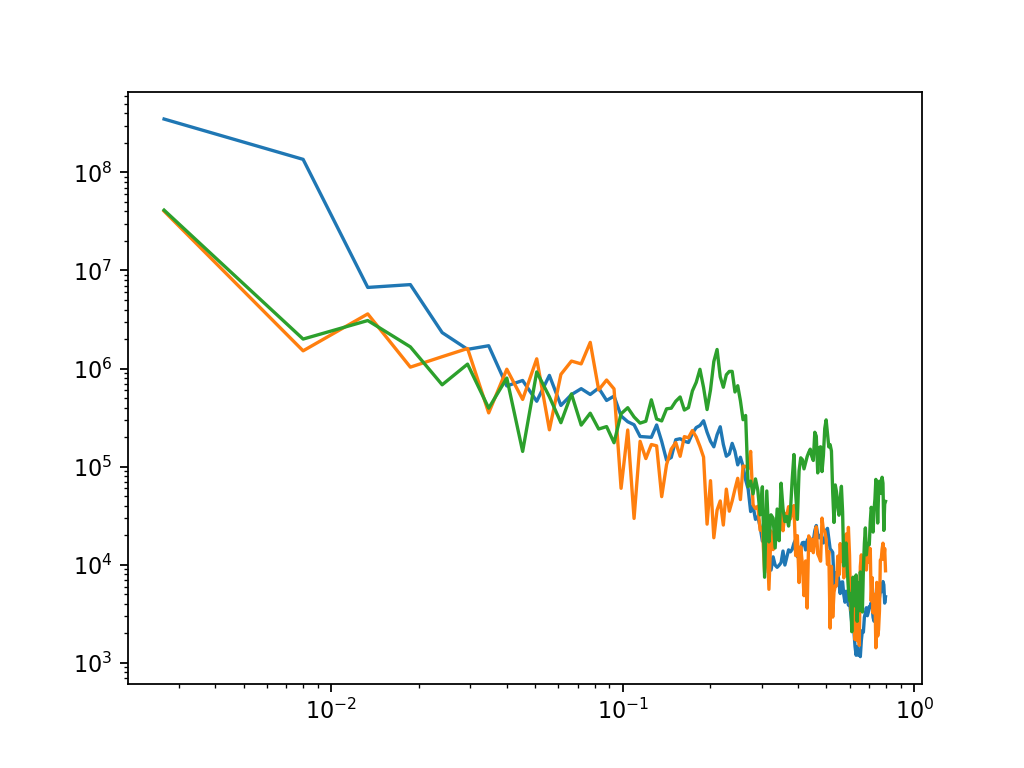

In [34]:
qr = np.sqrt(qx**2+qy**2)
qstart = 0
qend   = 0.8
bins = 151
q = (np.linspace(qstart,qend,bins)[1:] + np.linspace(qstart,qend,bins)[:-1])/2
qr1,dqr1 = np.histogram(qr,bins=np.linspace(qstart,qend,bins),weights=np.ones(qr.shape))

is1 = np.abs(pttn)
In11,dI1 = np.histogram(qr,bins=np.linspace(qstart,qend,bins),weights=is1)
In11 /= qr1

is1 = np.abs(pttn_new)
In21,dI1 = np.histogram(qr,bins=np.linspace(qstart,qend,bins),weights=is1)
In21 /= qr1

plt.subplots()
plt.loglog(q,In11)
plt.subplots()
plt.loglog(q,In21)
plt.loglog(q,np.mean(pttn_new[148:162,151:],axis=0))
plt.loglog(q,np.mean(pttn_new[151:,148:162],axis=1))

In [ ]:
#np.savez('mtc_saxs_rect_l6w2_vr60_rsig4.npz',q=q,I1=In11,I2=In21,im=im,x0=x0,y0=y0,im_new=im_new,x0_new=x0_new,y0_new=y0_new)

In [48]:
In11_h = np.copy(In11)
In21_h = np.copy(In21)

In [11]:
ls

hard_sphere_simulate.ipynb     mtc_saxs_rect_l6w2_vr40.npz
mtc_saxs.npz                   mtc_saxs_rect_l6w2_vr40_rsig8.npz
mtc_saxs_r1p8_vr60.npz         mtc_saxs_rect_l6w2_vr60_2.npz
mtc_saxs_rect_l6w2_vr40_2.npz  rect_random.ipynb


In [12]:
q1 = np.load('mtc_saxs_rect_l6w2_vr40_rsig8.npz')['q']
I1 = np.load('mtc_saxs_rect_l6w2_vr40_rsig8.npz')['I1']
I2 = np.load('mtc_saxs_rect_l6w2_vr40_rsig8.npz')['I2']

<IPython.core.display.Javascript object>


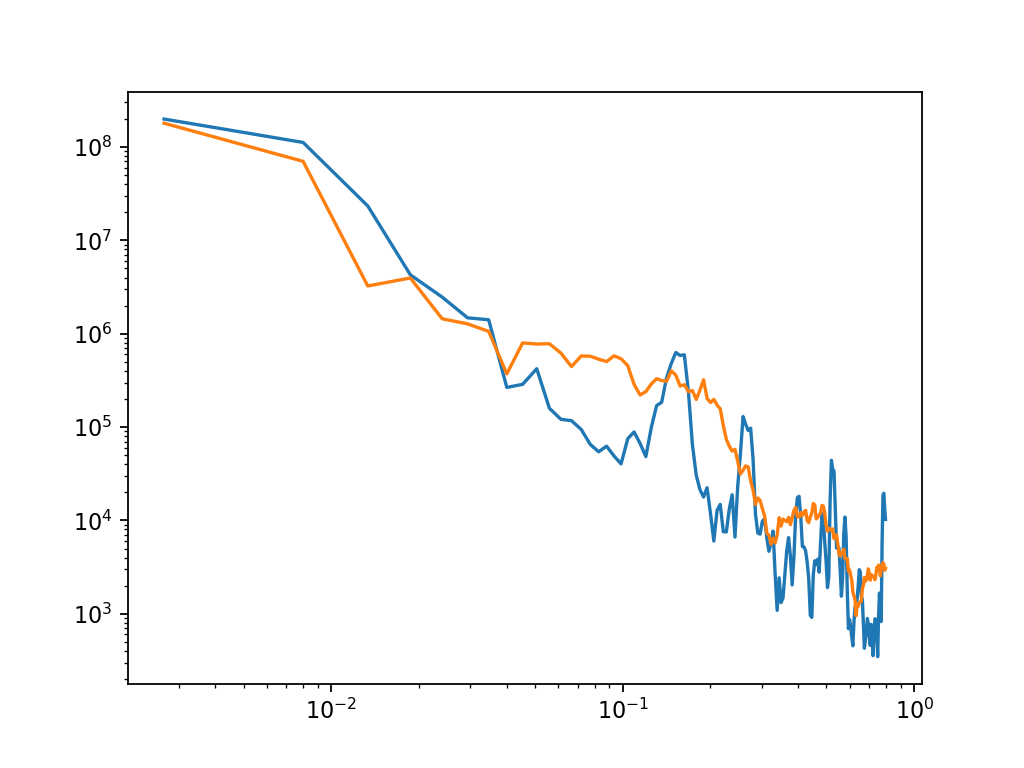

In [13]:
plt.subplots()
plt.loglog(q1,I1,q1,I2)